# Looking for signals of attention (and other mental states) in macaque V2

In [61]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import torch
import pickle
import os.path
import numpy as np
from matplotlib.pyplot import *
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import utils
import lvutils as lv
import mattplotlib as m
import modellib

def redo():
    reload(utils)
    reload(lv)
    reload(m)
    reload(modellib)

In [62]:
# load the data
data = utils.load_data('ki_0503_V2b_py.mat')

../../data/hn/ ki_0503_V2b_py.mat
Loaded ki_0503_V2b_py.mat
118679 frames, 31 units, 848 trials with 116 frames each
  Time embedding...
  Time embedding...


In [72]:
data.__getitem__(0)['dfs'].shape, data.__getitem__(0)['stim'].shape, data.__getitem__(0)['robs'].shape

(torch.Size([31]), torch.Size([132]), torch.Size([31]))

In [73]:
data.stim_dims

[1, 11, 1, 12]

In [74]:
data.val_inds.shape, data.train_inds.shape

((25426,), (76293,))

In [76]:
data.val_inds.shape[0] + data.train_inds.shape[0]

101719

In [89]:
data.cov_dims

{}

<a id='section1'></a>
# 1) fit model - autoencoder + GLM, 3 LVs

In [53]:
# only train if the model does not exist
if True: # not os.path.isfile('model_2_ki_0503_V2b_py.pickle'):
    # add the smoothed robs into the model as a covariate
    sm_robs100 = lv.smooth(data.robs, n=100)
    data.add_covariate('smoothed_robs', sm_robs100)
    # TODO: need to put this in the model
    
    
    # train the drift model (to "straighten out the plot")
    LLsNULL, drift_net, drift_mod = modellib.train_drift(data)
    # train the glm with the drift model
    LLs0, glm = modellib.train_glm_with_drift(data, drift_net, drift_mod)
    # add the glm to the autoencoder as input
    LLs, model = modellib.train_autoencoder_and_glm(data, num_latents=3, pretrained_glm=glm)
    
    print(np.mean(LLs), np.mean(LLsNULL), np.mean(LLs-LLsNULL))

Mean LL-null: 2.5085218
Model: M031_N_NN_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 26.23125171661377 sec elapsed
0.4516227 2.5085218 -2.0568993


stim None
robs None
None [0, 1]


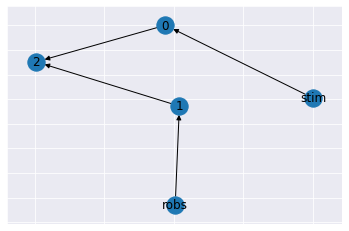

In [88]:
import networkx as nx
g = nx.DiGraph()

for netidx, network in enumerate(model.networks):
    g.add_node(netidx)
    
    # add edges between data and networks
    if network.xstim_n is not None:
        g.add_edge(network.xstim_n, netidx)
    
    # add edges between networks
    if network.ffnets_in is not None:
        for inputidx in network.ffnets_in:
            g.add_edge(inputidx, netidx)
            # attribute the edge if the network type is something
            if network.network_type is not None:
                g[inputidx][netidx]['type'] = network.network_type
    # inputs to each network
    # QUESTION: can a network have ffnets_in and xstim_n?
    print(network.xstim_n, network.ffnets_in)

# draw the network
nx.draw_networkx(g)

In [54]:
sm_robs100 = lv.smooth(data.robs, n=100)
data.add_covariate('smoothed_robs', sm_robs100)
data[0].keys()
# TODO: add the smoothed_robs into the FFnetwork

dict_keys(['stim', 'robs', 'dfs', 'Xdrift', 'smoothed_robs'])

In [55]:
# save out the model for later use
if not os.path.isfile('model_2_ki_0503_V2b_py.pickle'):
    with open('model_2_ki_0503_V2b_py.pickle', 'wb') as f:
        pickle.dump(model, f)

<a id='section2'></a>
# 2) analyze latents

In [56]:
# load the saved out latents
model = utils.load_model('model_2_ki_0503_V2b_py.pickle')
R = utils.construct_R_matrix(data)
Z = utils.construct_Z_matrix(R, model, num_latents=3)
Z.shape # trials X time X latents

(848, 121, 3)

# Draw the network we just trained

In [60]:
# modellib.draw_network(model)
# model.networks[1].layers[0].input_dims

for network in drift_mod.networks:
    print(network.network_type)
    for layer in network.layers:
        print(layer.input_dims, '-->', layer.output_dims)

normal
[1, 1, 1, 10] --> [31, 1, 1, 1]


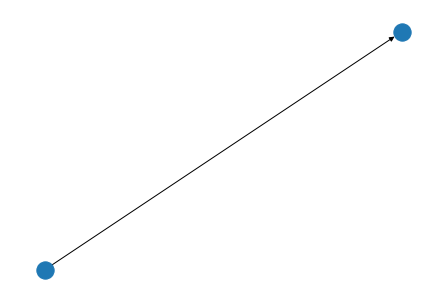

In [58]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()
g.add_node("A")
g.add_node("B")
g.add_edge("A", "B")

nx.draw(g)
plt.show()

/tmp/ipykernel_18369/3021170030.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/tmp/ipykernel_18369/3021170030.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


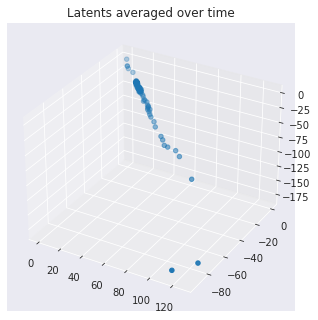

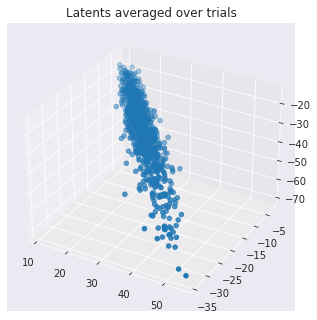

In [22]:
# plot the latents averaged over time
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(Z, axis=0).T[0],
           np.mean(Z, axis=0).T[1],
           np.mean(Z, axis=0).T[2])
plt.title("Latents averaged over time")

## 2a plot latents averaged over trials
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(np.mean(Z, axis=1).T[0],
           np.mean(Z, axis=1).T[1],
           np.mean(Z, axis=1).T[2])
plt.title("Latents averaged over trials")

plt.show()

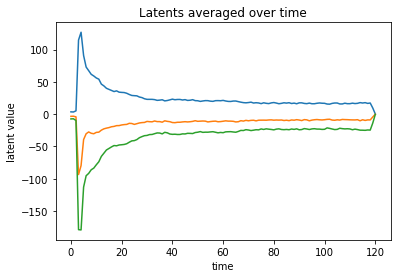

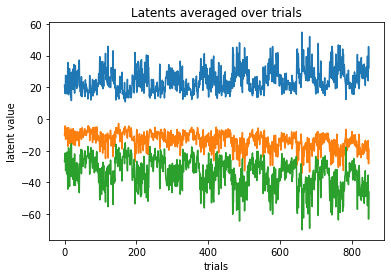

In [8]:
## 2b plotted latents averaged over time
fig = plt.figure()
plt.plot(np.mean(Z, axis=0).T[0])
plt.plot(np.mean(Z, axis=0).T[1])
plt.plot(np.mean(Z, axis=0).T[2])
plt.title("Latents averaged over time")
plt.xlabel("time")
plt.ylabel("latent value")

## 2c plotted latents averaged over trials
fig = plt.figure()
plt.plot(np.mean(Z, axis=1).T[0])
plt.plot(np.mean(Z, axis=1).T[1])
plt.plot(np.mean(Z, axis=1).T[2])
plt.title("Latents averaged over trials")
plt.xlabel("trials")
plt.ylabel("latent value")
plt.show()

<a id='section3'></a>
# 3) look at cued vs. uncued as a proxy for attention

In [9]:
## 3a find centroids of latents for cued and uncued trials
trcued = np.where(data.TRcued < 0)[0]
truncued = np.where(data.TRcued > 0)[0]
trcued_mean = np.mean(np.mean(Z[trcued], axis=1), axis=0)
truncued_mean = np.mean(np.mean(Z[truncued], axis=1), axis=0)

## 3b calculate vector between the centroids
centroid_vector = trcued_mean - truncued_mean
centroid_vector /= np.sqrt(centroid_vector @ centroid_vector.T)
centroid_vector = np.array([centroid_vector])

## 3c fit logistic regression model between cued and uncued
# separate cued-uncued points via logistic regression instead of centroids
from sklearn.linear_model import LogisticRegression

cued_trial_model = LogisticRegression(random_state=0).fit(np.mean(Z, axis=1), data.TRcued)

## 3d calculate hyperplane vector
hyperplane_vector = (cued_trial_model.coef_ / np.sqrt(cued_trial_model.coef_ @ cued_trial_model.coef_.T))

print("Hyperplane Vector", hyperplane_vector)
print("Centroid Vector  ", centroid_vector)

Hyperplane Vector [[-0.03316789  0.68496262 -0.72782285]]
Centroid Vector   [[-0.55693449  0.32768119  0.76318347]]


<a id='section4'></a>
# 4) project latents onto cued vs. uncued vector

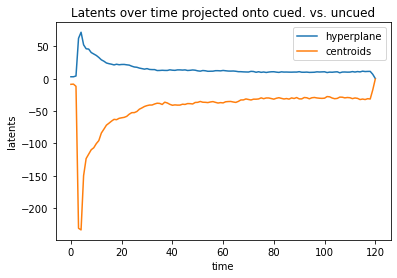

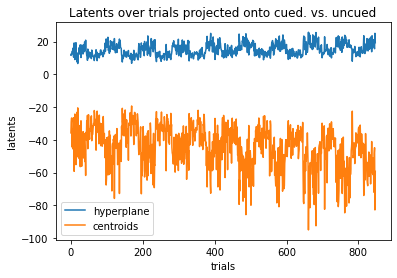

In [10]:
## 4a project the latents over time onto the cued vs. uncued vectors
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z, axis=0).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=0).T).T, label="centroids")
plt.title("Latents over time projected onto cued. vs. uncued")
plt.xlabel("time")
plt.ylabel("latents")
plt.legend()

## 4b project the latents over trials onto the cued vs. uncued vectors
fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z, axis=1).T).T, label="hyperplane")
plt.plot((centroid_vector @ np.mean(Z, axis=1).T).T, label="centroids")
plt.title("Latents over trials projected onto cued. vs. uncued")
plt.xlabel("trials")
plt.ylabel("latents")
plt.legend()
plt.show()

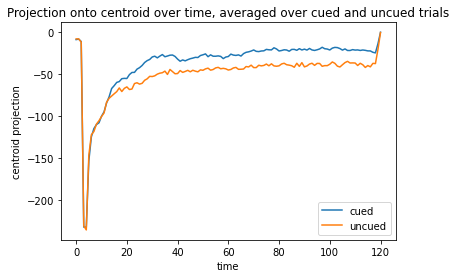

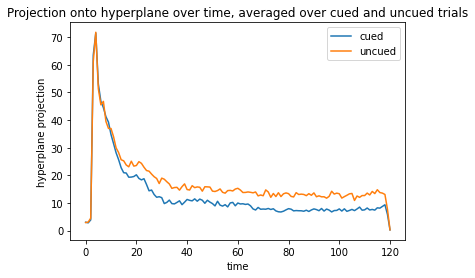

In [11]:
fig = plt.figure()
plt.plot((centroid_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((centroid_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("centroid projection")
plt.title("Projection onto centroid over time, averaged over cued and uncued trials")

fig = plt.figure()
plt.plot((hyperplane_vector @ np.mean(Z[trcued], axis=0).T).T, label="cued")
plt.plot((hyperplane_vector @ np.mean(Z[truncued], axis=0).T).T, label="uncued")
plt.legend()
plt.xlabel("time")
plt.ylabel("hyperplane projection")
plt.title("Projection onto hyperplane over time, averaged over cued and uncued trials")
plt.show()

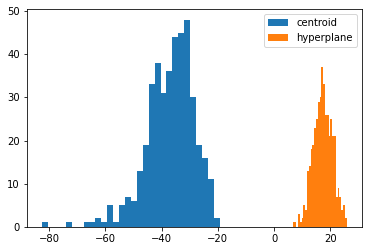

In [12]:
fig = plt.figure()
plt.hist((centroid_vector @ np.mean(Z[trcued], axis=1).T).T, bins=30, label="centroid")
plt.hist((hyperplane_vector @ np.mean(Z[truncued], axis=1).T).T, bins=30, label="hyperplane")
plt.legend()
plt.show()

# plot attention signal over time for some trials

In [104]:
redo()
z = utils.get_z(data, model)
trialzs = [z[data.block_inds[i]] for i in range(len(data.block_inds))]
width = 6
trialzs_grid, height = m.list_to_grid(trialzs[:60], width=width)  

In [105]:
width, height

(6, 10)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

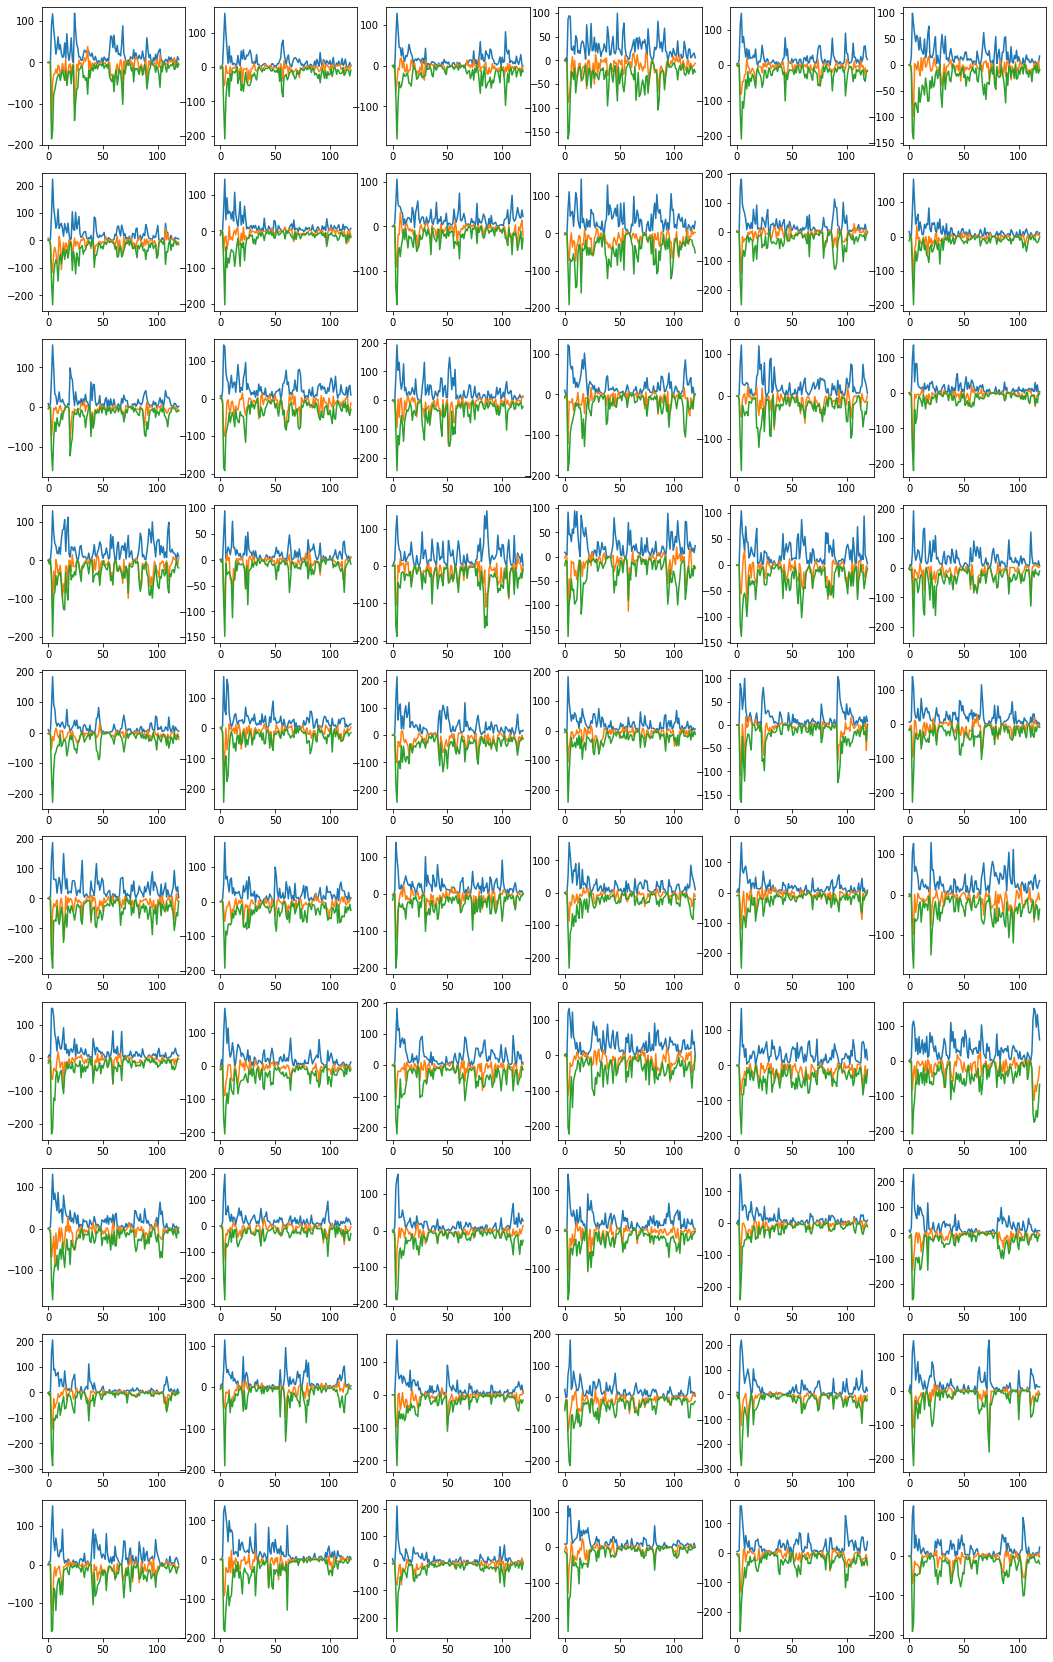

In [111]:
m.fig()
fig, axs = plt.subplots(height, width, figsize=(width*3, height*3))
for i in range(height):
    for j in range(width):
        axs[i,j].plot(trialzs_grid[i][j])
plt.show()

<a id='section6'></a>
# TODO: retrain models with different #'s of latents and rerun everything, is it better?

# TODO: determine D-prime between cued vs. uncued

# SCRATCH

In [37]:
redo()
z = utils.get_z(data, model)
z.shape

/home/mattjac/projects/mattjac/lvs/utils.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/torch/csrc/utils/tensor_new.cpp:204.)
  z = torch.array([z_i.detach().numpy() for z_i in z])  # convert each to a numpy array


torch.Size([118679, 3])

<Figure size 432x288 with 0 Axes>

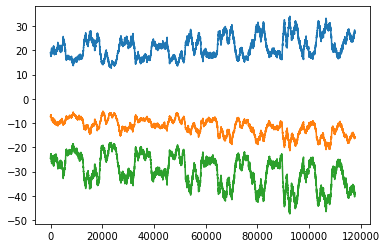

In [38]:
m.fig()
plt.plot(lv.movavg(z[:, 0], n=1000))
plt.plot(lv.movavg(z[:, 1], n=1000))
plt.plot(lv.movavg(z[:, 2], n=1000))
plt.show()

In [39]:
z.shape, data.robs.shape

(torch.Size([118679, 3]), torch.Size([118679, 31]))

In [40]:
data.stim.shape

torch.Size([118679, 132])